In [1]:
%cd ..

/Users/pavanpreetgandhi/git-repos/interpretable-sla


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV
from source.fit_predict_score_utils import fit_and_predict, build_score_df, calibrate_score_df, compute_metrics

In [3]:
nof_non_feature_cols = 5  # speaker_id, subset, part, part_score, overall_score

In [4]:
datasets = {}
dataset_paths = sorted([f for f in os.listdir('datasets') if f.endswith('.parquet')])
for dataset_path in dataset_paths:
    dataset_name = os.path.splitext(dataset_path)[0]
    df = pd.read_parquet(os.path.join('datasets', dataset_path))
    if dataset_name != '7_qwen_2_5_omni_embeddings':
        features = df.columns[nof_non_feature_cols:]
        df[features] = np.exp(df[features])
    datasets[os.path.splitext(dataset_path)[0]] = df

In [5]:
alpha_range = np.logspace(-6, 6, 100)
experiments = [
    {
        "name": "Original Question Set",
        "dataset": datasets["1_original_question_set"],
        "features": datasets["1_original_question_set"].columns[nof_non_feature_cols:],
        "pipeline": Pipeline([("model", RidgeCV(alphas=alpha_range))]),
    },
    {
        "name": "Direct Scoring with Rubric",
        "dataset": datasets["2_direct_scoring_with_rubric"],
        "features": datasets["2_direct_scoring_with_rubric"].columns[nof_non_feature_cols:],
        "pipeline": Pipeline([("model", RidgeCV(alphas=alpha_range))]),
    },
    {
        "name": "Rubric Based Questions",
        "dataset": datasets["3_rubric_based_questions"],
        "features": datasets["3_rubric_based_questions"].columns[nof_non_feature_cols:],
        "pipeline": Pipeline([("model", RidgeCV(alphas=alpha_range))]),
    },
    {
        "name": "Qwen 2.5 Omni Embeddings",
        "dataset": datasets["7_qwen_2_5_omni_embeddings"],
        "features": datasets["7_qwen_2_5_omni_embeddings"].columns[nof_non_feature_cols:],
        "pipeline": Pipeline([
            ("scaler", StandardScaler()),
            ("model", RidgeCV(alphas=alpha_range))
        ]),
    }
]

In [6]:
def get_simulated_low_data_df(df: pd.DataFrame, keep_fraction: float) -> pd.DataFrame:
    """
    Simulate a low-data regime by keeping only a fraction of the training data.
    Ensures that all parts are represented in the reduced training set.
    """
    df_train = df[df['subset'] == 'train']
    df_reduced = df[df['subset'] != 'train']
    for part in [1, 3, 4, 5]:
        df_train_part = df_train[df_train['part']==part]
        n_keep = max(1, int(len(df_train_part) * keep_fraction))
        df_train_part_reduced = df_train_part.sample(n=n_keep)
        df_reduced = pd.concat([df_train_part_reduced, df_reduced], axis=0)
    return df_reduced

In [7]:
results = {}
alphas = []
n_samples = 100
TRAIN_PORTIONS = [
    0.002, 0.003, 0.004, 0.005, 0.008, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 
    0.045, 0.05, 0.06, 0.07, 0.08, 0.09, 0.10, 0.12, 0.14, 0.16, 0.18, 0.20,
    0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.60, 0.70, 0.80, 0.90, 1.00
]
for experiment in experiments:
    print(f"Running experiment: {experiment['name']}")
    results[experiment['name']] = {}
    for train_portion in TRAIN_PORTIONS:
        pccs = []
        rmses = []
        for i in range(n_samples):
            np.random.seed(i)
            df_reduced = get_simulated_low_data_df(
                experiment["dataset"], 
                keep_fraction=train_portion
            )
            predictions, pipelines = fit_and_predict(
                df=df_reduced,
                features=experiment["features"],
                pipeline=experiment["pipeline"],
            )
            for part, pipeline in pipelines.items():
                alphas.append(pipeline.named_steps['model'].alpha_)
            score_df = build_score_df(
                df=experiment["dataset"],
                predictions=predictions,
            )
            calibrated_score_df = calibrate_score_df(score_df)
            metrics = compute_metrics(
                score_df=calibrated_score_df,
                n_bootstraps=1,
                subsets=["train", "dev", "eval"],
            )
            pcc = metrics['dev']['overall']['pcc'][0]
            rmse = metrics['dev']['overall']['rmse'][0]
            pccs.append(pcc)
            rmses.append(rmse)
        mean_pcc = np.mean(pccs)
        std_pcc = np.std(pccs)
        mean_rmse = np.mean(rmses)
        std_rmse = np.std(rmses)
        results[experiment['name']][train_portion] = {
            "mean_pcc": mean_pcc,
            "std_pcc": std_pcc,
            "mean_rmse": mean_rmse,
            "std_rmse": std_rmse
        }
        print(f"  Train Portion: {train_portion:.4f} | PCC: {mean_pcc:.4f} ± {std_pcc:.4f} | RMSE: {mean_rmse:.4f} ± {std_rmse:.4f} | Alpha: {np.mean(alphas):.4f}")
        alphas = []

Running experiment: Original Question Set
  Train Portion: 0.0020 | PCC: 0.7048 ± 0.0410 | RMSE: 0.4721 ± 0.0244 | Alpha: 185003.2168
  Train Portion: 0.0030 | PCC: 0.7195 ± 0.0309 | RMSE: 0.4626 ± 0.0202 | Alpha: 112502.6679
  Train Portion: 0.0040 | PCC: 0.7304 ± 0.0255 | RMSE: 0.4552 ± 0.0174 | Alpha: 67501.8318
  Train Portion: 0.0050 | PCC: 0.7396 ± 0.0189 | RMSE: 0.4488 ± 0.0134 | Alpha: 60001.3451
  Train Portion: 0.0080 | PCC: 0.7489 ± 0.0148 | RMSE: 0.4421 ± 0.0108 | Alpha: 5001.0740
  Train Portion: 0.0100 | PCC: 0.7512 ± 0.0166 | RMSE: 0.4403 ± 0.0121 | Alpha: 2500.6615
  Train Portion: 0.0150 | PCC: 0.7616 ± 0.0110 | RMSE: 0.4323 ± 0.0084 | Alpha: 0.6594
  Train Portion: 0.0200 | PCC: 0.7673 ± 0.0080 | RMSE: 0.4279 ± 0.0063 | Alpha: 0.4317
  Train Portion: 0.0250 | PCC: 0.7719 ± 0.0078 | RMSE: 0.4242 ± 0.0063 | Alpha: 0.3520
  Train Portion: 0.0300 | PCC: 0.7758 ± 0.0076 | RMSE: 0.4210 ± 0.0062 | Alpha: 0.2447
  Train Portion: 0.0350 | PCC: 0.7785 ± 0.0069 | RMSE: 0.4188 ± 

In [8]:
# Plot results with seaborn
plot_data = []
for experiment_name, train_portion_results in results.items():
    for train_portion, metrics_dict in train_portion_results.items():
        plot_data.append({
            'Experiment': experiment_name,
            'Train Portion': train_portion,
            'Mean PCC': metrics_dict['mean_pcc'],
            'Std PCC': metrics_dict['std_pcc'],
            'Mean RMSE': metrics_dict['mean_rmse'],
            'Std RMSE': metrics_dict['std_rmse']
        })
plot_df = pd.DataFrame(plot_data)
plot_df

,Experiment,Train Portion,Mean PCC,Std PCC,Mean RMSE,Std RMSE
0,Original Question Set,0.002,0.704760,4.097697e-02,0.472068,2.441211e-02
1,Original Question Set,0.003,0.719527,3.094966e-02,0.462588,2.023064e-02
2,Original Question Set,0.004,0.730440,2.546100e-02,0.455176,1.736742e-02
3,Original Question Set,0.005,0.739605,1.888241e-02,0.448817,1.337053e-02
4,Original Question Set,0.008,0.748881,1.480270e-02,0.442050,1.083938e-02
...,...,...,...,...,...,...
135,Qwen 2.5 Omni Embeddings,0.600,0.824081,2.246805e-03,0.378059,2.182552e-03
136,Qwen 2.5 Omni Embeddings,0.700,0.825935,1.789857e-03,0.376255,1.751763e-03
137,Qwen 2.5 Omni Embeddings,0.800,0.827347,1.501559e-03,0.374873,1.476220e-03
138,Qwen 2.5 Omni Embeddings,0.900,0.828759,1.096712e-03,0.373482,1.083932e-03


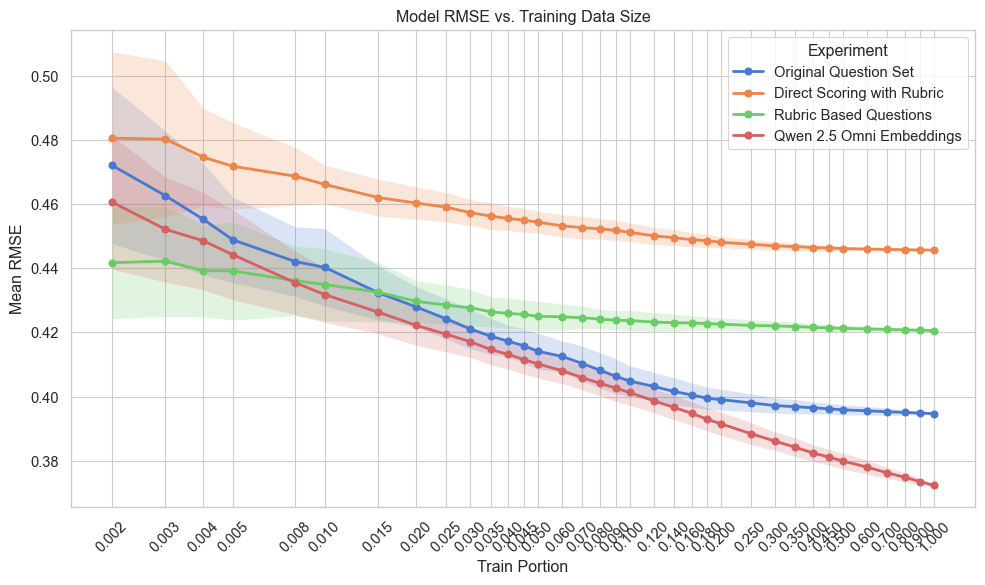

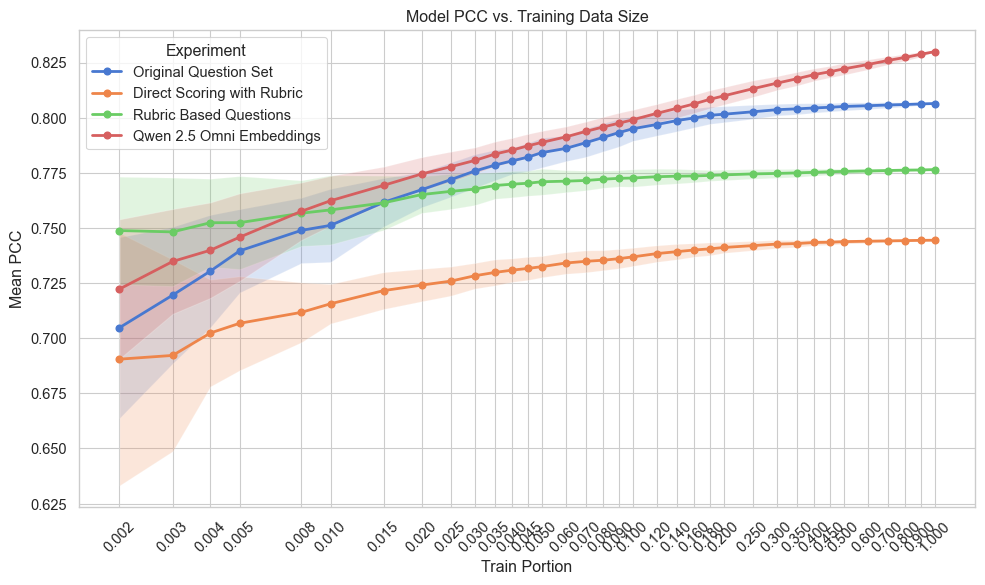

In [11]:
# Plot RMSE with error bands
plt.figure(figsize=(10, 6))
for experiment in plot_df['Experiment'].unique():
    df_exp = plot_df[plot_df['Experiment'] == experiment]
    plt.plot(df_exp['Train Portion'], df_exp['Mean RMSE'], marker='o', lw=2, label=experiment)
    plt.fill_between(
        df_exp['Train Portion'],
        df_exp['Mean RMSE'] - df_exp['Std RMSE'],
        df_exp['Mean RMSE'] + df_exp['Std RMSE'],
        alpha=0.2
    )
plt.xscale('log')
plt.xlabel('Train Portion')
plt.ylabel('Mean RMSE')
plt.title('Model RMSE vs. Training Data Size')
plt.legend(title='Experiment')
plt.xticks(TRAIN_PORTIONS, [f"{portion:.3f}" for portion in TRAIN_PORTIONS], rotation=45)
plt.tight_layout()
plt.savefig('report/images/low_data_regime_rmse.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot PCC with error bands
plt.figure(figsize=(10, 6))
for experiment in plot_df['Experiment'].unique():
    df_exp = plot_df[plot_df['Experiment'] == experiment]
    plt.plot(df_exp['Train Portion'], df_exp['Mean PCC'], marker='o', lw=2, label=experiment)
    plt.fill_between(
        df_exp['Train Portion'],
        df_exp['Mean PCC'] - df_exp['Std PCC'],
        df_exp['Mean PCC'] + df_exp['Std PCC'],
        alpha=0.2
    )
plt.xscale('log')
plt.xlabel('Train Portion')
plt.ylabel('Mean PCC')
plt.title('Model PCC vs. Training Data Size')
plt.legend(title='Experiment')
plt.xticks(TRAIN_PORTIONS, [f"{portion:.3f}" for portion in TRAIN_PORTIONS], rotation=45)
plt.tight_layout()
plt.savefig('report/images/low_data_regime_pcc.png', dpi=300, bbox_inches='tight')
plt.show()